In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay
from catboost import CatBoostClassifier
from phik.report import plot_correlation_matrix
import optuna
import phik

In [141]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

Описание столбцов:

Name: фамилия участника.\
Gender: пол участника.\
Age: возраст участника.\
City: город, в котором находится участник.\
Working Professional or Student: работает ли участник или является студентом.\
Profession: профессия участника.\
Academic Pressure: уровень академической нагрузки по шкале от 1 до 5.\
Work Pressure: уровень рабочей нагрузки по шкале от 1 до 5.\
CGPA: средний балл успеваемости.\
Study Satisfaction: уровень удовлетворенности участника своей учебой по шкале от 1 до 5.\
Job Satisfaction: уровень удовлетворенности участника своей работой по шкале от 1 до 5.\
Sleep Duration: средняя продолжительность сна.\
Dietary Habits: информация о предпочтениях участника в еде.\
Degree: высшая степень участника.\
Have you ever had suicidal thoughts ?: были ли мысли о самоубийстве.\
Work/Study Hours: среднее количество часов, затрачиваемых на работу или/и учебу ежедневно.\
Financial Stress: уровень финансового стресса, который вы испытываете по шкале от 1 до 5.\
Family History of Mental Illness: наличие психических заболеваний в семье.\
Depression: показывает, подвержен ли участник риску депрессии.

In [143]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                     27897 non-null   

In [144]:
train.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


### Обработка данных

In [146]:
# Сделаем копии данных и будем работать с копиями
copy_train = train.drop(columns=['id', 'Name'], errors='ignore')
copy_test = test.drop(columns=['id', 'Name'], errors='ignore')

In [147]:
# Функция для обработки столбца Dietary Habits
def map_dietary_habits(value):
    mapping = {
        'Moderate': 'Moderate',
        'Unhealthy': 'Unhealthy',
        'Healthy': 'Healthy',
        'Yes': 'Healthy',
        'No': 'Unhealthy',
        'More Healthy': 'Healthy',
        'No Healthy': 'Unhealthy',
        'Vegas': 'Moderate',
        'Hormonal': 'Moderate',
        'Less Healthy': 'Moderate',
        'Less than Healthy': 'Moderate',
    }
    return mapping.get(value, np.nan)

In [148]:
#Функция для обработки столбца Sleep Duration
def map_sleep_duration(value):
    mapping = {
        'Less than 5 hours': 4,
        '7-8 hours': 7,
        'More than 8 hours': 9,
        '5-6 hours': 5,
        '3-4 hours': 4,
        '6-7 hours': 6,
        '4-5 hours': 4,
        '2-3 hours': 3,
        '4-6 hours': 5,
        '6-8 hours': 7,
        '1-6 hours': 6,
        '9-11 hours': 10,
        '10-11 hours': 10,
        '45': 4,
        '8-9 hours': 8,
        '10-6 hours': 8,
        '9-5': 7,
        '3-6 hours': 5,
        'than 5 hours': 6,
        '9-6 hours': 7,
        '8 hours': 8,
        '1-3 hours': 3,
        '1-2 hours': 2,
        '9-5 hours': 7 
    }
    return mapping.get(value, np.nan)

In [149]:
def update_data(df):
    # Заполнение столбца Profession для студентов
    df.loc[df['Working Professional or Student'] == 'Student', 'Profession'] = 'Student'

    # Объединение столбцов Work Pressure и Academic Pressure
    df["Work Pressure"] = df["Work Pressure"].fillna(df["Academic Pressure"])

    # Объединение столбцов Job Satisfaction и Study Satisfaction
    df["Job Satisfaction"] = df["Job Satisfaction"].fillna(df["Study Satisfaction"])

    # Переименование столбцов и удаление лишних
    df.rename(columns={'Work Pressure': 'Pressure', 'Job Satisfaction': 'Satisfaction'}, inplace=True)
    df = df.drop(columns=['Academic Pressure', 'Study Satisfaction'], errors='ignore')

    return df

In [150]:
def replace_rare_values(df):
    # Замена редких значений в Degree
    rare_degrees = df["Degree"].value_counts()[df["Degree"].value_counts() <= 5].index
    df["Degree"] = df["Degree"].replace(rare_degrees, 'Other')
    
    # Замена редких значений в Profession
    rare_professions = df["Profession"].value_counts()[df["Profession"].value_counts() <= 5].index
    df["Profession"] = df["Profession"].replace(rare_professions, 'Other')

    return df

In [151]:
def fill_missing_values(df):
    # Заполнение пропусков в столбце Profession
    df['Profession'] = df['Profession'].fillna(
        df.groupby('Gender')['Profession']
        .transform(lambda x: x[~(x == 'Student')].mode()[0] if not x[~(x == 'Student')].mode().empty else np.nan)
    )
    
    # Заполнение пропусков в категориальных столбцах
    for column in ['Satisfaction', 'Pressure', 'Dietary Habits', 'Degree', 'Financial Stress']:
        if column in df:
            mode = df[column].mode()[0]
            df[column] = df[column].fillna(mode)
    
    # Заполнение пропусков в столбце Sleep Duration
    if 'Sleep Duration' in df:
        mean = round(df['Sleep Duration'].mean())
        df['Sleep Duration'] = df['Sleep Duration'].fillna(mean)
    
    # Заполнение столбца CGPA только для студентов
        if 'CGPA' in df and 'Working Professional or Student' in df:
            median = df[df['Profession'] == 'Student']['CGPA'].median()
            df.loc[df['Working Professional or Student'] == 'Student', 'CGPA'] = (df.loc[df['Working Professional or Student'] == 'Student', 'CGPA'].fillna(median)) 
        return df

In [152]:
# Применение всех функций
def preprocess_data(df):
    df["Dietary Habits"] = df["Dietary Habits"].apply(map_dietary_habits)
    df["Sleep Duration"] = df["Sleep Duration"].apply(map_sleep_duration)
    df = update_data(df)
    df = replace_rare_values(df)
    df = fill_missing_values(df)
    return df

copy_train = preprocess_data(copy_train)
copy_test = preprocess_data(copy_test)

In [153]:
numeric_col = copy_train.select_dtypes(include=['int64', 'float64']).columns
copy_train[numeric_col].describe()

,Age,Pressure,CGPA,Satisfaction,Sleep Duration,Work/Study Hours,Financial Stress,Depression
count,140700.000000,140700.000000,27907.000000,140700.000000,140700.000000,140700.000000,140700.000000,140700.000000
mean,40.388621,3.027406,7.658672,2.968443,6.180512,6.252679,2.988955,0.181713
std,12.384099,1.401842,1.464231,1.405178,1.912156,3.853615,1.413623,0.385609
min,18.000000,1.000000,5.030000,1.000000,2.000000,0.000000,1.000000,0.000000
25%,29.000000,2.000000,6.290000,2.000000,4.000000,3.000000,2.000000,0.000000
50%,42.000000,3.000000,7.770000,3.000000,5.000000,6.000000,3.000000,0.000000
75%,51.000000,4.000000,8.920000,4.000000,7.000000,10.000000,4.000000,0.000000
max,60.000000,5.000000,10.000000,5.000000,10.000000,12.000000,5.000000,1.000000


### Построение графиков

#### Распределение числовых признаков

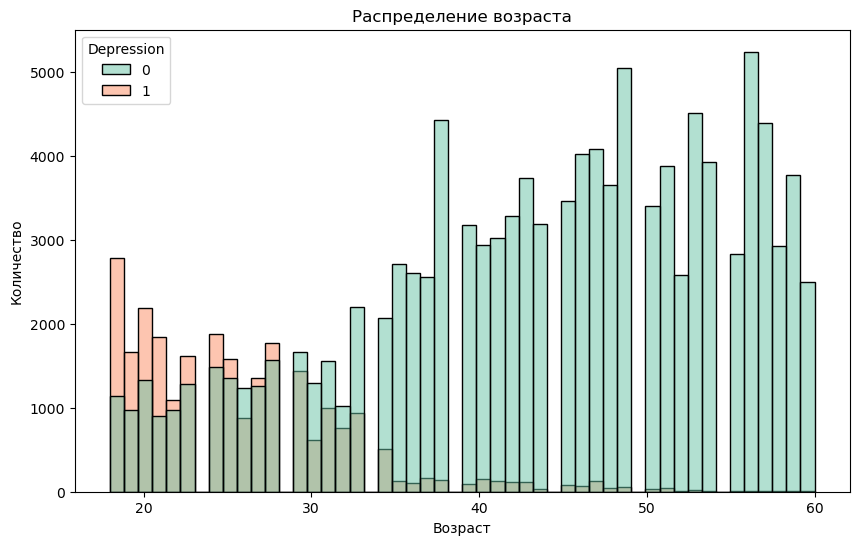

In [156]:
plt.figure(figsize=(10, 6))
sns.histplot(data=copy_train, x='Age', hue='Depression', palette='Set2', edgecolor='black')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('Распределение возраста')
plt.show()

Text(0.5, 1.0, 'Распределение возраста')

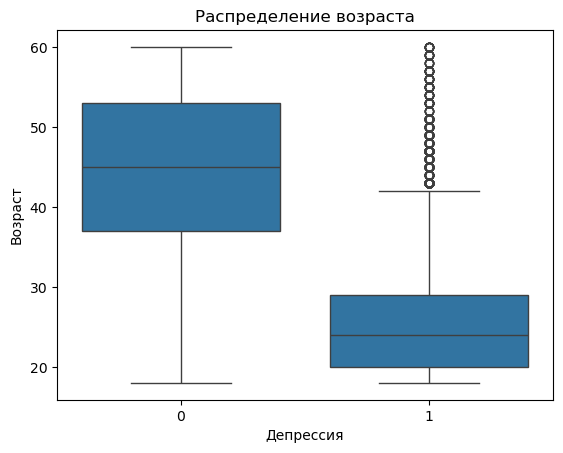

In [157]:
sns.boxplot(data=copy_train, y='Age', x='Depression')
plt.xlabel('Депрессия')
plt.ylabel('Возраст')
plt.title('Распределение возраста')

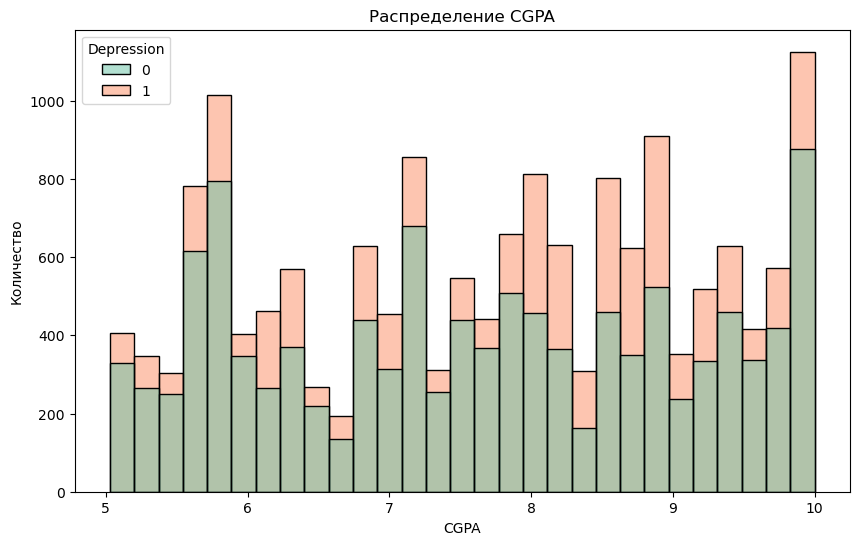

In [158]:
plt.figure(figsize=(10, 6))
sns.histplot(data=copy_train, x='CGPA', hue='Depression', palette='Set2', edgecolor='black')
plt.xlabel('CGPA')
plt.ylabel('Количество')
plt.title('Распределение CGPA')
plt.show()

#### Распределение категориальных признаков

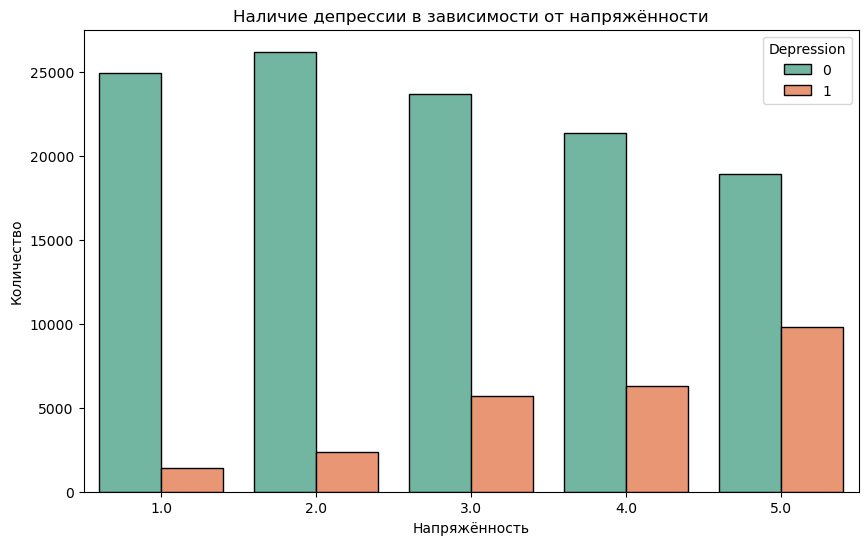

In [160]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Pressure', data=copy_train, palette='Set2', hue='Depression', edgecolor='black')
plt.xlabel('Напряжённость')
plt.ylabel('Количество')
plt.title('Наличие депрессии в зависимости от напряжённости')
plt.show()

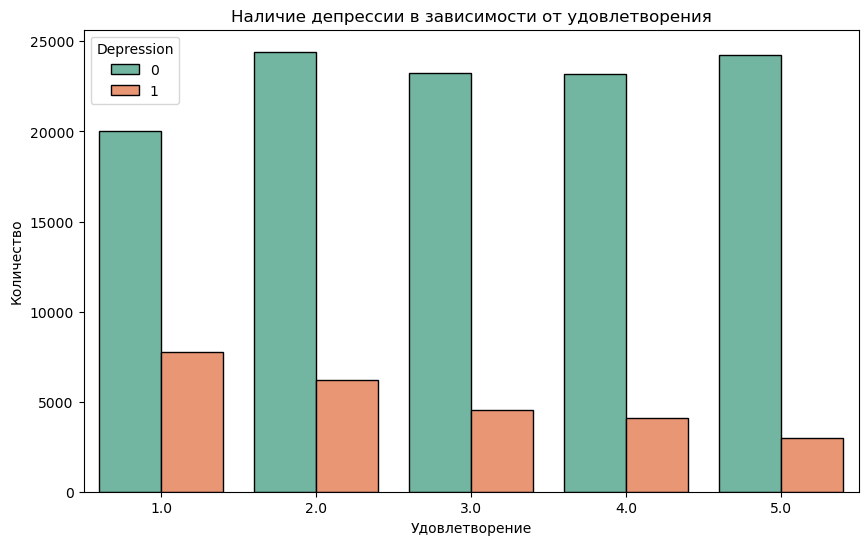

In [161]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Satisfaction', data=copy_train, palette='Set2', hue='Depression', edgecolor='black')
plt.xlabel('Удовлетворение')
plt.ylabel('Количество')
plt.title('Наличие депрессии в зависимости от удовлетворения')
plt.show()

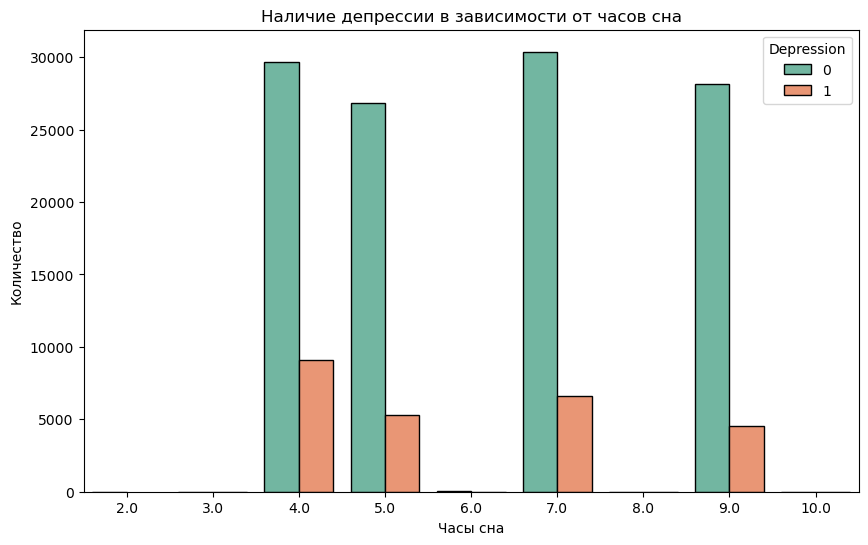

In [162]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Sleep Duration', data=copy_train, palette='Set2', hue='Depression', edgecolor='black')
plt.xlabel('Часы сна')
plt.ylabel('Количество')
plt.title('Наличие депрессии в зависимости от часов сна')
plt.show()

interval columns not set, guessing: ['Age', 'Pressure', 'CGPA', 'Satisfaction', 'Sleep Duration', 'Work/Study Hours', 'Financial Stress', 'Depression']


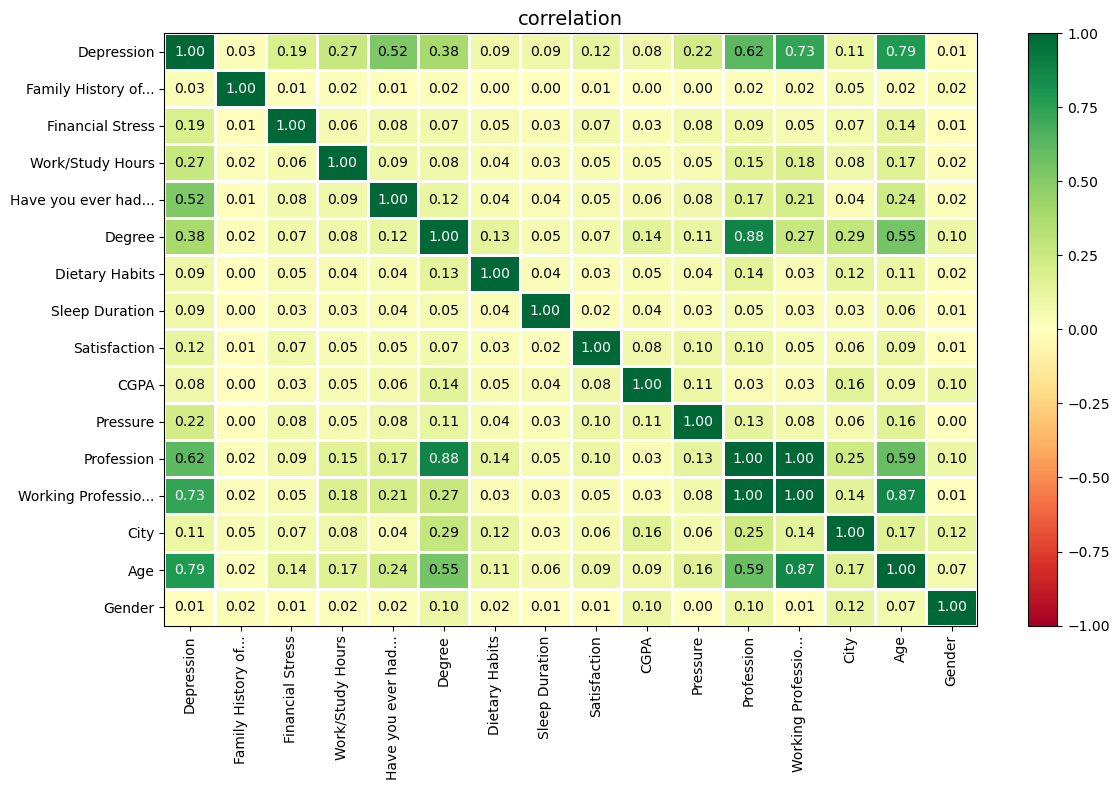

In [163]:
# Построение матрицы корреляции. Иипользуем для этого коэффициент phi_K
phik_overview = copy_train.phik_matrix()
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, figsize=(12, 8))

In [164]:
# Кодирование категориальных переменных
def fit_and_transform_encoder(train_df, test_df):
    categorical_col = train_df.select_dtypes(include=['object']).columns
    
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    encoder.fit(train_df[categorical_col])
    
    train_df[categorical_col] = encoder.transform(train_df[categorical_col])
    test_df[categorical_col] = encoder.transform(test_df[categorical_col])

fit_and_transform_encoder(copy_train, copy_test)

### Обучение модели Cat Boost

In [166]:
# Разделение данных на тестовую и обучающие выборки
X = copy_train.drop(columns='Depression')
y = copy_train['Depression']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [167]:
# Метод кросс-валидации
cat_boost = CatBoostClassifier(verbose=0)

cv = StratifiedKFold(n_splits=5, shuffle=True)
scores = cross_val_score(cat_boost, X, y, cv=cv, scoring="roc_auc")
scores.mean()

0.9747460609541404

In [168]:
# Подборка гиперпараметров с помощью Optuna
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'depth': trial.suggest_int('depth', 4, 10),  # Глубина деревьев
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.001, 10, log=True),
        'random_strength': trial.suggest_float('random_strength', 0.01, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'verbose': 0,
        'eval_metric': 'AUC',
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=False)
    
    y_pred = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    return auc

In [169]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=3600)

params = study.best_trial.params

print("Лучшие параметры:")
print(study.best_trial.params)
print("Лучший результат:")
print(study.best_value)

[I 2025-01-19 00:14:30,253] A new study created in memory with name: no-name-c7c6c721-d4dc-4ca3-b680-fda874b802b2
[I 2025-01-19 00:14:35,034] Trial 0 finished with value: 0.974101365589313 and parameters: {'iterations': 456, 'learning_rate': 0.0376887452952258, 'depth': 8, 'l2_leaf_reg': 0.004883223632951374, 'random_strength': 2.0337313167355475, 'bagging_temperature': 0.25371963269604747, 'border_count': 231}. Best is trial 0 with value: 0.974101365589313.
[I 2025-01-19 00:14:42,319] Trial 1 finished with value: 0.9738956214463439 and parameters: {'iterations': 684, 'learning_rate': 0.00924676641797599, 'depth': 8, 'l2_leaf_reg': 0.2836296544475284, 'random_strength': 7.289911226240552, 'bagging_temperature': 0.11858234119062006, 'border_count': 229}. Best is trial 0 with value: 0.974101365589313.
[I 2025-01-19 00:14:43,074] Trial 2 finished with value: 0.9658728527177404 and parameters: {'iterations': 604, 'learning_rate': 0.002423037897282825, 'depth': 7, 'l2_leaf_reg': 0.009446816

Лучшие параметры:
{'iterations': 838, 'learning_rate': 0.0642043541615562, 'depth': 4, 'l2_leaf_reg': 1.4640091798707071, 'random_strength': 7.2500823785216335, 'bagging_temperature': 0.6155665023613146, 'border_count': 224}
Лучший результат:
0.9748928497678695


In [170]:
# Обучение модели с подобранными параметрами
model = CatBoostClassifier(**params)
model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=False)

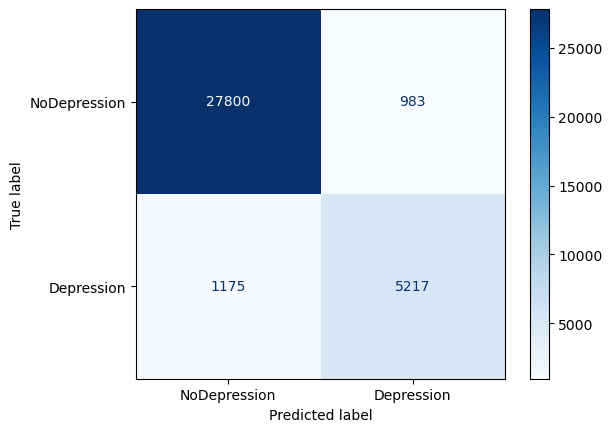

In [171]:
# Построим матрицу ошибок, чтобы наглядно увидеть какие ошибки и в каком количестве совершает модель
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NoDepression','Depression'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [172]:
# Предскажем результаты на тестовых данных и выгрузим в файл 
test_preds = model.predict(copy_test)

output = pd.DataFrame({'id': test['id'],
                       'Depression': test_preds})
output.to_csv('submission.csv', index=False)